<a href="https://colab.research.google.com/github/fhzh123/CAU_mAI/blob/main/AI%ED%95%B5%EC%8B%AC%EB%8F%99%ED%96%A5_%EC%8B%A4%EC%8A%B5%EC%9E%90%EB%A3%8C_2_(Optimizer).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 군AI교육지원사업

## WEEK 2 - Regularization & Optimization

### Optimization

Optimizer는 학습 데이터셋을 이용하여 모델을 학습할 때 실제 데이터와 모델이 예측한 결과를 기반으로 모델이 잘 학습할 수 있도록 해주는 역할을 합니다.

1. 먼저 우리가 만든 모델에 Training Data가 들어가면 Output 값이 나옵니다.
2. 우리는 그 Output값이 목표로 하는 타겟값과 가까워지도록 Error Function ( = loss function)을 설정하고 Error 값이 줄어드는 방향으로 학습시키기 위해 각 Weight와 갖는 Gradient값을 계산합니다.
3. 이를 활용해 weight들을 다시 설정합니다.
4. 1~3 과정을 반복(Epoch)하며 최적의 Weight를 갖는 모델을 찾아냅니다.

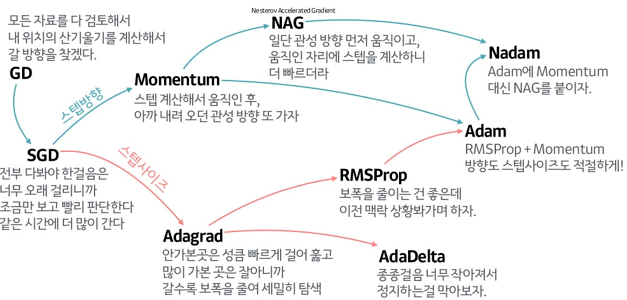

In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
class model:
    def __init__(self, x, y):
        self.x = x
        self.y = y

        self._initalize_parameters()
        self._initalize_moms()
        self._initalize_RMSs()

    def _initalize_parameters(self):
        self.weights_1 = self._random_tensor((x.shape[1],3))
        self.bias_1 = self._random_tensor(1)
        self.weights_2 = self._random_tensor((3,1))
        self.bias_2 = self._random_tensor(1)

    def _random_tensor(self, size): return (torch.randn(size)).requires_grad_()

    def _initalize_moms(self):
        self.moms_w1, self.moms_b1 = [0], [0]
        self.moms_w2, self.moms_b2 = [0], [0]

    def _initalize_RMSs(self):
        self.RMSs_w1, self.RMSs_b1 = [0], [0]
        self.RMSs_w2, self.RMSs_b2 = [0], [0]

    def _nn(self, xb):
        l1 = xb @ self.weights_1 + self.bias_1
        l2 = l1.max(torch.tensor(0.0)) # Relu
        l3 = l2 @ self.weights_2 + self.bias_2
        return l3

    def _loss_func(self, preds, yb):
        return ((preds-yb)**2).mean()

    def train(self, optimizer):
        lrs = [1e-6,1e-4,1e-2,1]
        fig, axs = plt.subplots(2,2)

        all_losses = list()
        for i, lr in enumerate(lrs):
            losses = list()
            while(len(losses) == 0 or losses[-1] > 0.1 and len(losses) < 1000):
                preds = self._nn(self.x)
                loss = self._loss_func(preds, self.y)
                loss.backward()

                optimizer(self.weights_1, lr, self.moms_w1, self.RMSs_w1)
                optimizer(self.bias_1, lr, self.moms_b1, self.RMSs_b1)
                optimizer(self.weights_2, lr, self.moms_w2, self.RMSs_w2)
                optimizer(self.bias_2, lr, self.moms_b2, self.RMSs_b2)

                losses.append(loss.item())
            all_losses.append(losses)

            # 데이터 시각화
            xi = i%2
            yi = int(i/2)
            axs[xi,yi].plot(list(range(len(losses))), losses)
            axs[xi,yi].set_ylim(0, 30)
            axs[xi,yi].set_title('Learing Rate: '+str(lr))

            # 비교 실험을 위해 이전에 학습한 모델의 가중치 값들을 다시 초기화해줍니다.
            torch.manual_seed(42)
            self._initalize_parameters()
            self._initalize_moms()
            self._initalize_RMSs()

        # 데이터 시각화
        for ax in axs.flat:
            ax.set(xlabel='steps', ylabel='loss (MSE)')
        plt.tight_layout()

In [ ]:
import numpy as np
import pandas as pd

url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
input_df = pd.read_csv(url,header=None)

In [ ]:
import torch.nn.functional as F

x = torch.FloatTensor(input_df.values[:,:5][:50])
y = torch.FloatTensor(input_df.values[:,5][:50])

In [ ]:
x = F.normalize(x, dim=0)

In [ ]:
my_model = model(x, y)

#### SGD (Stochastic Gradient Descent)

Stochastic Gradient Descent는 가장 기초가 되는 옵티마이저입니다. 전체 데이터가 아닌 미니 배치단위로 기울기를 계싼합니다.

모델의 가중치는 해당 가중치에서 학습률과 그래디언트를 빼서 업데이트됩니다.

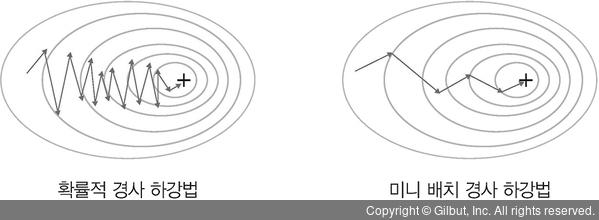

In [ ]:
def SGD(a, lr, _, __):
    a.data -= a.grad * lr
    a.grad = None

In [ ]:
my_model.train(SGD)

#### Momentum

SGD의 문제점은 경사가 가파르거나 완만한 지역에서 모두 동일하게 이동한다는 점입니다. 즉 Saddle Point에서 학습이 종료될 수 있습니다.

그래서 Momentum을 주는 방식이 개발되었습니다. 해당 방식은 최적해를 향해 진행하던 속도에 관성을 주어 SGD가 가지고 있던 문제를 해결하고자 했습니다.

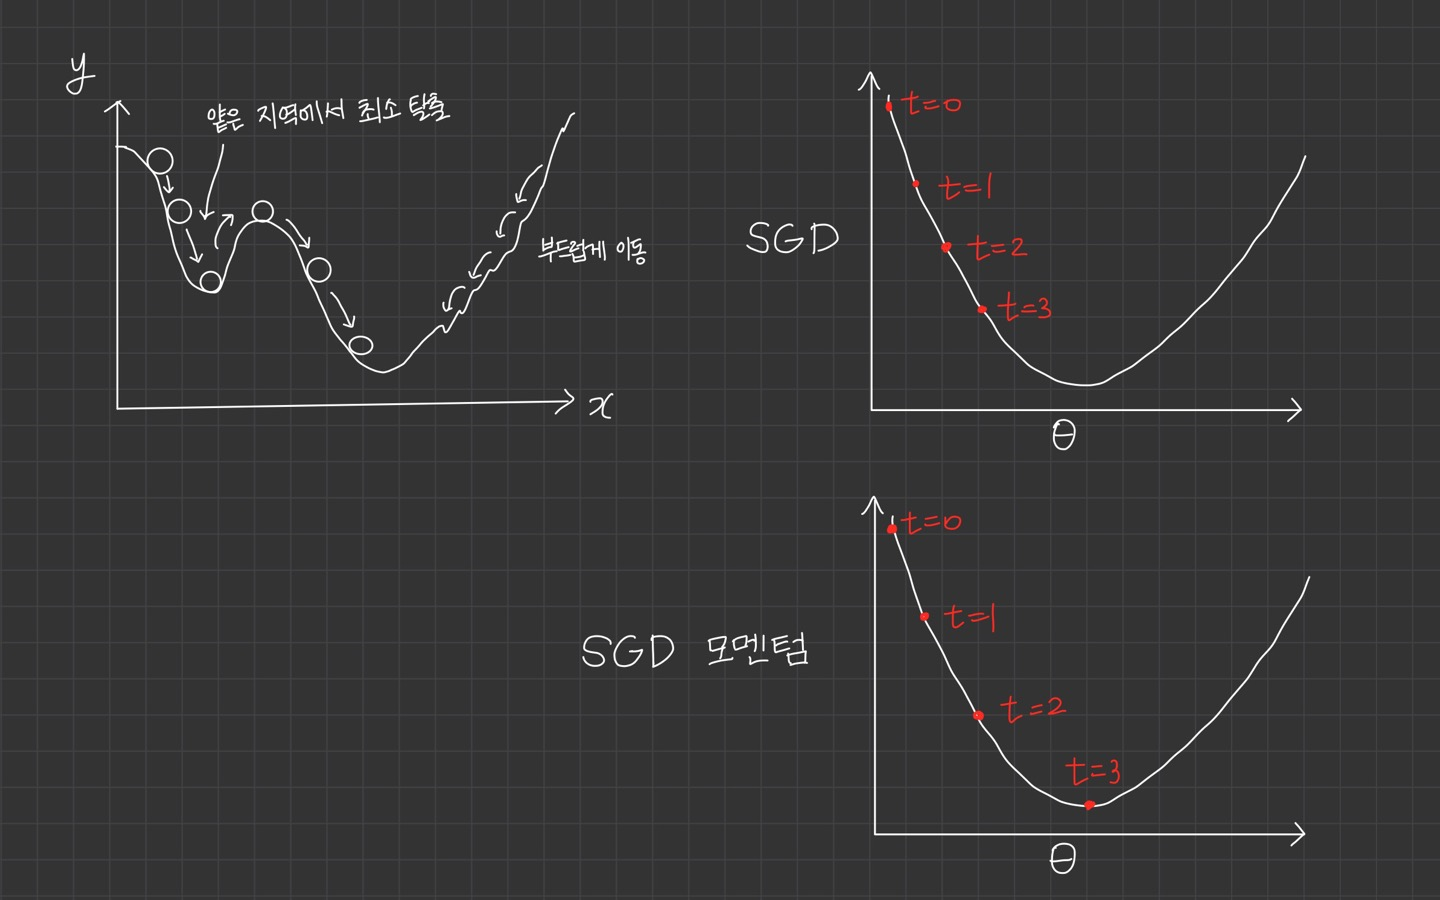

In [ ]:
def momentum(a, _, moms, __):
    previous_momentum = moms[-1]

    mom = a.grad * 0.1 + previous_momentum * 0.9
    moms.append(mom)
    a.data -= mom
    a.grad = None

In [ ]:
my_model.train(momentum)

#### RMSprop

RMSprop은 기울기가 제곱된다는 점을 제외하면 모멘텀과 동일합니다.

기울기가 제곱이기 때문에 큰 값에 대해서는 커지고 작은 값에 대해서는 작아질 수 있습니다.

In [ ]:
def RMSprop(a, lr, _, RMSs):
    previous_RMS = RMSs[-1]

    RMS = (a.grad ** 2 * 0.1 + previous_RMS * 0.9)
    RMSs.append(RMS)
    # Gamma is added to make sure there is never divide with zero
    gamma = 1E-5
    a.data -= (a.grad * lr) / (torch.sqrt(RMS) + gamma)
    a.grad = None


In [ ]:
my_model.train(RMSprop)

#### Adam

Adam 옵티마이저는 Momentum과 RMSprop를 합쳐두었습니다. 적절하게 합침으로써 각 방식의 장점을 취할 수 있었습니다.

In [ ]:
def Adam(a, lr, moms, RMSs):
    previous_momentum = moms[-1]
    mom = a.grad * 0.1 + previous_momentum * 0.9
    moms.append(mom)

    previous_RMS = RMSs[-1]
    RMS = a.grad ** 2 * 0.1 + previous_RMS * 0.9
    RMSs.append(RMS)

    gamma = 1E-5
    a.data -= (mom * lr) / (torch.sqrt(RMS) + gamma)
    a.grad = None


In [ ]:
my_model.train(Adam)

### Advanced Examples

In [ ]:
len(input_df)

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

In [ ]:
import torch
from torch.utils.data.dataset import Dataset

class CustomDataset(Dataset):
    def __init__(self, src_list, trg_list):

        self.src_tensor = torch.FloatTensor(src_list)
        self.trg_tensor = torch.FloatTensor(trg_list)

        self.num_data = len(self.src_tensor)

    def __getitem__(self, index):
        return self.src_tensor[index], self.trg_tensor[index]

    def __len__(self):
        return self.num_data

In [ ]:
train_dataset = CustomDataset(src_list=input_df.values[:,:13][:450], trg_list=input_df.values[:,13][:450])
train_dataloader = DataLoader(train_dataset, drop_last=False, batch_size=16)

test_dataset = CustomDataset(src_list=input_df.values[:,:13][450:], trg_list=input_df.values[:,13][450:])
test_dataloader = DataLoader(test_dataset, drop_last=False, batch_size=16)

In [ ]:
for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

In [ ]:
# 학습에 사용할 CPU나 GPU 장치를 얻습니다.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# 모델을 정의합니다.
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(13, 3),
            nn.ReLU(),
            nn.Linear(3, 1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

In [ ]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # 예측 오류 계산
        pred = model(X)
        loss = loss_fn(pred, y)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(f"Test Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 30
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

In [ ]:
epochs = 30
model = NeuralNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, eps=1e-8)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")